# DSCI 598 Fall 2022
* Malcolm Nichols
* Jeff Fossi
* Cameron Lauf
* Samson Beza

# Load Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import optuna
import lightgbm as lgb
import optuna.visualization as optvis

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score 
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from keras.utils import np_utils
import scikitplot

import warnings
warnings.filterwarnings('ignore')

# Load and combine CSV Files  
We are going to load in and combine our predictions from Four seperate models for the training, validation, and testing data. We will then create a meta-model and train that on the validation set.

### Train

In [2]:
#Train
m1_train_array = np.loadtxt('/kaggle/input/ensemble-files/Ensemble Files/Model_1_train_pred.csv', delimiter=',')
m2_train_array = np.loadtxt('/kaggle/input/ensemble-files/Ensemble Files/Model_2_train_pred.csv', delimiter=',')
m3_train_array = np.loadtxt('/kaggle/input/ensemble-files/Ensemble Files/Model_3_train_pred.csv', delimiter=',')
m4_train_array = np.loadtxt('/kaggle/input/ensemble-files/Ensemble Files/Model_4_train_pred.csv', delimiter=',')

#Combine and print new array
train_combined = np.hstack([
    m1_train_array,
    m2_train_array,
    m3_train_array,
    m4_train_array
])

print(f'{train_combined[:3]}\n\n{train_combined.shape}')

[[1.67296320e-01 1.07304690e-03 7.34673800e-02 2.83470170e-03
  1.62028100e-01 1.09196910e-02 5.82380700e-01 1.21246230e-01
  1.10128750e-03 5.61067200e-02 2.01553830e-04 3.68991850e-01
  9.59193330e-04 4.51393130e-01 1.37518640e-01 1.22022770e-02
  2.85219580e-01 1.96413790e-02 4.29645300e-01 1.89019680e-02
  9.68709300e-02 2.59233500e-04 5.13681650e-08 2.69839400e-03
  3.81564080e-01 5.54535100e-02 1.35292390e-04 5.59889440e-01]
 [1.51712420e-02 9.73065600e-01 6.81595400e-03 4.63546520e-04
  4.39682840e-03 2.60838910e-05 6.07695500e-05 4.90562760e-03
  1.22457200e-05 1.04678825e-01 5.91902160e-03 3.68135750e-01
  8.46906200e-03 5.07879500e-01 1.50795060e-01 6.67855840e-03
  1.15112560e-01 8.37279300e-03 3.09539620e-01 4.74515140e-03
  4.04756280e-01 3.89332320e-03 4.16951340e-06 9.73775400e-02
  5.67054050e-05 1.24822065e-01 7.11953040e-01 6.18931950e-02]
 [9.60056300e-01 1.46727860e-03 2.01768820e-02 1.16503100e-02
  1.11849260e-03 5.33278600e-03 1.97917210e-04 2.45181600e-04
  5.87

### Validation (training set)

In [3]:
#Validation
m1_val_array = np.loadtxt('/kaggle/input/ensemble-files/Ensemble Files/Model_1_val_pred.csv', delimiter=',')
m2_val_array = np.loadtxt('/kaggle/input/ensemble-files/Ensemble Files/Model_2_val_pred.csv', delimiter=',')
m3_val_array = np.loadtxt('/kaggle/input/ensemble-files/Ensemble Files/Model_3_val_pred.csv', delimiter=',')
m4_val_array = np.loadtxt('/kaggle/input/ensemble-files/Ensemble Files/Model_4_val_pred.csv', delimiter=',')

#Combine and print new array
val_combined = np.hstack([
    m1_val_array,
    m2_val_array,
    m3_val_array,
    m4_val_array
])

print(val_combined.shape)

(14355, 28)


### Test

In [4]:
#Test
m1_test_array = np.loadtxt('/kaggle/input/ensemble-files/Ensemble Files/Model_1_test_pred.csv', delimiter=',')
m2_test_array = np.loadtxt('/kaggle/input/ensemble-files/Ensemble Files/Model_2_test_pred.csv', delimiter=',')
m3_test_array = np.loadtxt('/kaggle/input/ensemble-files/Ensemble Files/Model_3_test_pred.csv', delimiter=',')
m4_test_array = np.loadtxt('/kaggle/input/ensemble-files/Ensemble Files/Model_4_test_pred.csv', delimiter=',')

#Combine and print new array
test_combined = np.hstack([
    m1_test_array,
    m2_test_array,
    m3_test_array,
    m4_test_array
])

print(test_combined.shape)

(7178, 28)


# Prepare Labels

In [5]:
df = pd.read_csv('../input/challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv')

df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [6]:
df['pixels'] = [np.fromstring(x, dtype=int, sep=' ').reshape(-1,48,48,1) for x in df['pixels']]
img_array = np.concatenate(df.pixels)

le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)

In [7]:
_,_,_,y_valid = train_test_split(img_array, img_labels, shuffle=True, stratify=img_labels, test_size=0.5, random_state=1)

In [8]:
print(f'{y_valid.shape}\n\n{y_valid[:10]}')

(14355, 7)

[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]


In [9]:
ys_valid = np.argmax(y_valid, axis=1)
print(ys_valid[:10])

[3 2 3 4 3 6 6 3 3 6]


# Model Selection

## Decision Tree Classifier

In [10]:
%%time 

dt_clf = DecisionTreeClassifier(random_state=1)

dt_parameters = {
    'max_depth': [3,4,10,12,14,16],
    'min_samples_leaf': [1,3,5,7],
}

dt_grid = GridSearchCV(dt_clf, dt_parameters, cv=10, n_jobs=-1, refit='True', verbose=0, scoring='accuracy')
dt_grid.fit(val_combined, ys_valid)

dt_model = dt_grid.best_estimator_

print('Best Parameters:', dt_grid.best_params_)
print('Best CV Score:  ', dt_grid.best_score_)
print('Training Acc:   ', dt_model.score(val_combined, ys_valid))

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 3}
Best CV Score:   0.6300976871487777
Training Acc:    0.7243469174503657
CPU times: user 1.5 s, sys: 160 ms, total: 1.66 s
Wall time: 30.7 s


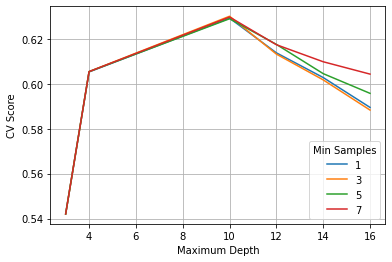

 max_depth  min_samples_leaf  cv_score
         3                 1  0.542042
         3                 3  0.542042
         3                 5  0.542042
         3                 7  0.542042
         4                 1  0.605296
         4                 3  0.605435
         4                 5  0.605435
         4                 7  0.605435
        10                 1  0.629261
        10                 3  0.630098
        10                 5  0.628982
        10                 7  0.629748
        12                 1  0.613794
        12                 3  0.613237
        12                 5  0.617556
        12                 7  0.617416
        14                 1  0.602789
        14                 3  0.601743
        14                 5  0.604529
        14                 7  0.609823
        16                 1  0.589483
        16                 3  0.588299
        16                 5  0.595750
        16                 7  0.604319


In [11]:
dt_summary = pd.DataFrame(dt_grid.cv_results_['params'])
dt_summary['cv_score'] = dt_grid.cv_results_['mean_test_score']

for ms in dt_parameters['min_samples_leaf']:
    temp = dt_summary.query(f'min_samples_leaf == {ms}')
    plt.plot(temp.max_depth, temp.cv_score, label=ms)
plt.xlabel('Maximum Depth')
plt.ylabel('CV Score')
plt.legend(title='Min Samples')
plt.grid()
plt.show()

print(dt_summary.to_string(index=False))

## Save Model

In [12]:
import joblib
joblib.dump(dt_model, 'meta_model_1.joblib')

['meta_model_1.joblib']

## Random Forest

In [13]:
%%time 
rf_clf = RandomForestClassifier(random_state=1, n_estimators=650)

rf_parameters = {
    'max_depth': [12,20],
    'min_samples_leaf': [1,3]
}

rf_grid = GridSearchCV(rf_clf, rf_parameters, cv=10, refit='True', n_jobs=-1, verbose=0, scoring='accuracy')
rf_grid.fit(val_combined, ys_valid)

rf_model = rf_grid.best_estimator_

print('Best Parameters:', rf_grid.best_params_)
print('Best CV Score:  ', rf_grid.best_score_)
print('Training Acc:   ', rf_model.score(val_combined, ys_valid))

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1}
Best CV Score:   0.6868012675550552
Training Acc:    0.9971438523162661
CPU times: user 53.7 s, sys: 223 ms, total: 53.9 s
Wall time: 9min 22s


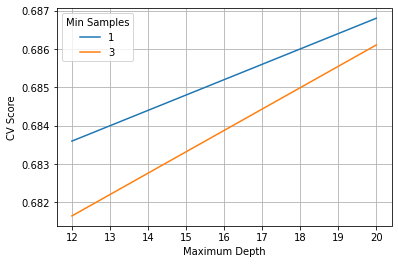

 max_depth  min_samples_leaf  cv_score
        12                 1  0.683598
        12                 3  0.681646
        20                 1  0.686801
        20                 3  0.686105


In [14]:
rf_summary = pd.DataFrame(rf_grid.cv_results_['params'])
rf_summary['cv_score'] = rf_grid.cv_results_['mean_test_score']

for ms in rf_parameters['min_samples_leaf']:
    temp = rf_summary.query(f'min_samples_leaf == {ms}')
    plt.plot(temp.max_depth, temp.cv_score, label=ms)
plt.xlabel('Maximum Depth')
plt.ylabel('CV Score')
plt.legend(title='Min Samples')
plt.grid()
plt.show()

print(rf_summary.to_string(index=False))

### Optuna for RandomForest Model

In [15]:
#increase max_depth param.
#min sample leaf at 1
#tweak other params?
def rf_objective(trial):
    n = trial.suggest_int('n_estimators',100,700)
    md = trial.suggest_int('max_depth', 2,50)
    msl = trial.suggest_int('min_samples_leaf',1,40)
    cr = trial.suggest_categorical('criterion',['gini','entropy'])
    
    rf_clf = RandomForestClassifier(
        n_estimators=n,max_depth=md,min_samples_leaf=msl
    )
    
    cv_scores = cross_val_score(rf_clf, val_combined, ys_valid, n_jobs=-1, cv=10, scoring='accuracy')
    score = cv_scores.mean()
    return score

In [16]:
%%time

rf_study = optuna.create_study(direction='maximize')
rf_study.optimize(rf_objective, n_trials=10)

print(rf_study.best_value)
print(rf_study.best_params)

[I 2022-12-06 23:49:38,763] A new study created in memory with name: no-name-5f095819-673c-428e-aafd-2843417125f6
[I 2022-12-06 23:50:52,751] Trial 0 finished with value: 0.682552289072433 and parameters: {'n_estimators': 351, 'max_depth': 17, 'min_samples_leaf': 6, 'criterion': 'entropy'}. Best is trial 0 with value: 0.682552289072433.
[I 2022-12-06 23:52:38,122] Trial 1 finished with value: 0.6763518969650499 and parameters: {'n_estimators': 604, 'max_depth': 27, 'min_samples_leaf': 28, 'criterion': 'entropy'}. Best is trial 0 with value: 0.682552289072433.
[I 2022-12-06 23:53:33,347] Trial 2 finished with value: 0.6763520910776158 and parameters: {'n_estimators': 298, 'max_depth': 34, 'min_samples_leaf': 22, 'criterion': 'entropy'}. Best is trial 0 with value: 0.682552289072433.
[I 2022-12-06 23:54:46,452] Trial 3 finished with value: 0.6737047839041861 and parameters: {'n_estimators': 443, 'max_depth': 50, 'min_samples_leaf': 39, 'criterion': 'gini'}. Best is trial 0 with value: 0.

0.682552289072433
{'n_estimators': 351, 'max_depth': 17, 'min_samples_leaf': 6, 'criterion': 'entropy'}
CPU times: user 593 ms, sys: 89.4 ms, total: 682 ms
Wall time: 9min 48s


In [17]:
%%time
rf_final_model = RandomForestClassifier(random_state=1, **rf_study.best_params)
rf_final_model.fit(val_combined, ys_valid)

CPU times: user 39.5 s, sys: 36.7 ms, total: 39.6 s
Wall time: 39.6 s


RandomForestClassifier(criterion='entropy', max_depth=17, min_samples_leaf=6,
                       n_estimators=351, random_state=1)

In [18]:
rf_final_model.score(val_combined,ys_valid)

0.8530825496342738

## LightGBM

In [19]:
def gb_objective(trial):
    """Function for tuning LightGBM"""
    md = trial.suggest_int('max_depth', 2,40)
    n = trial.suggest_int('n_estimators',20,250)
    mb = trial.suggest_int('max_bin',20,150)
    nl = trial.suggest_int('num_leaves', 20,300)
    ss = trial.suggest_float('subsample', 0.6,1, log=False)
    lr = trial.suggest_float('learning_rate',0,1, log=False)
    bt = trial.suggest_categorical('boosting_type',['gbdt','dart','goss'])
    
    gb_clf = lgb.LGBMClassifier(
        boosting_type=bt, max_depth=md, learning_rate=lr, n_estimators=n, subsample=ss, max_bin=mb, num_leaves=nl, random_state=1  
    )
    
    cv_scores = cross_val_score(gb_clf, val_combined, ys_valid, n_jobs=-1, cv=10, scoring='accuracy')
    score = cv_scores.mean()
    return score

In [20]:
%%time

gb_study = optuna.create_study(direction='maximize')
gb_study.optimize(gb_objective, n_trials=50)

print(f'Best Parameters: {gb_study.best_params}')
print(f'Best Score: {gb_study.best_value}')

[I 2022-12-07 00:00:07,872] A new study created in memory with name: no-name-57dab813-17a7-45f5-9a05-17dd6a7a2cea
[I 2022-12-07 00:00:21,787] Trial 0 finished with value: 0.49747153824502827 and parameters: {'max_depth': 33, 'n_estimators': 58, 'max_bin': 41, 'num_leaves': 182, 'subsample': 0.7422838810633395, 'learning_rate': 0.40802189042416137, 'boosting_type': 'gbdt'}. Best is trial 0 with value: 0.49747153824502827.
[I 2022-12-07 00:01:43,163] Trial 1 finished with value: 0.2071102462317898 and parameters: {'max_depth': 39, 'n_estimators': 148, 'max_bin': 86, 'num_leaves': 257, 'subsample': 0.660012695173477, 'learning_rate': 0.2868030115034693, 'boosting_type': 'dart'}. Best is trial 0 with value: 0.49747153824502827.
[I 2022-12-07 00:02:51,776] Trial 2 finished with value: 0.6739829957392292 and parameters: {'max_depth': 5, 'n_estimators': 218, 'max_bin': 26, 'num_leaves': 95, 'subsample': 0.861323715971128, 'learning_rate': 0.20135277470712643, 'boosting_type': 'dart'}. Best is

Best Parameters: {'max_depth': 20, 'n_estimators': 105, 'max_bin': 122, 'num_leaves': 260, 'subsample': 0.7151186371443902, 'learning_rate': 0.06400167064902969, 'boosting_type': 'gbdt'}
Best Score: 0.6849886929430378
CPU times: user 3.59 s, sys: 396 ms, total: 3.98 s
Wall time: 33min 19s


In [21]:
%%time
gb_final_model = lgb.LGBMClassifier(random_state=1, **gb_study.best_params)
gb_final_model.fit(val_combined, ys_valid)

CPU times: user 32.2 s, sys: 621 ms, total: 32.8 s
Wall time: 8.37 s


LGBMClassifier(learning_rate=0.06400167064902969, max_bin=122, max_depth=20,
               n_estimators=105, num_leaves=260, random_state=1,
               subsample=0.7151186371443902)

In [22]:
gb_final_model.score(val_combined,ys_valid)

0.9992337164750957

## Some Visualizations

In [23]:
def opt_plot(study, plot):
    """Function for printing"""
    if plot == 0: return optvis.plot_optimization_history(study)
    if plot == 1: return optvis.plot_slice(study)
    if plot == 2: return optvis.plot_parallel_coordinate(study)
    if plot == 3: return optvis.plot_contour(study)
    if plot == 4: return optvis.plot_param_importances(study)

In [24]:
opt_plot(gb_study,0)

In [25]:
opt_plot(gb_study,1)

In [26]:
opt_plot(gb_study,2)

In [27]:
opt_plot(gb_study,3)

In [28]:
opt_plot(gb_study,4)

## Logistic Regression Model

In [29]:
%%time 
lr_clf = LogisticRegression(max_iter=5000, penalty='l1', solver='saga', random_state=1)

lr_parameters = {
    'C': [0.01,0.05,0.1],
    'l1_ratio': [0,0.5,1]
}

lr_grid = GridSearchCV(lr_clf, lr_parameters, cv=10, refit='True', n_jobs=-1, verbose=0, scoring='accuracy')
lr_grid.fit(val_combined, ys_valid)

lr_model = lr_grid.best_estimator_

print('Best Parameters:', lr_grid.best_params_)
print('Best CV Score:  ', lr_grid.best_score_)
print('Training Acc:   ', lr_model.score(val_combined, ys_valid))

Best Parameters: {'C': 0.1, 'l1_ratio': 0}
Best CV Score:   0.6751677132569176
Training Acc:    0.6754440961337513
CPU times: user 1.09 s, sys: 35.6 ms, total: 1.13 s
Wall time: 21.2 s


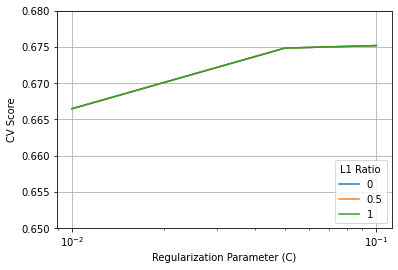

   C  l1_ratio  cv_score
0.01       0.0  0.666459
0.01       0.5  0.666459
0.01       1.0  0.666459
0.05       0.0  0.674820
0.05       0.5  0.674820
0.05       1.0  0.674820
0.10       0.0  0.675168
0.10       0.5  0.675168
0.10       1.0  0.675168


In [30]:
lr_summary = pd.DataFrame(lr_grid.cv_results_['params'])
lr_summary['cv_score'] = lr_grid.cv_results_['mean_test_score']

for r in lr_parameters['l1_ratio']:
    temp = lr_summary.query(f'l1_ratio == {r}')
    plt.plot(temp.C, temp.cv_score, label=r)
plt.xscale('log')
plt.ylim([0.65, 0.68])
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('CV Score')
plt.legend(title='L1 Ratio', loc='lower right')
plt.grid()
plt.show()

print(lr_summary.to_string(index=False))

# Load Test Labels

In [31]:
test_labels = pd.read_csv('../input/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv')
test_labels.columns = ['emotion', 'Usage', 'pixels']

test_labels = test_labels.query('Usage != "Training"')
test_labels.head()

,emotion,Usage,pixels
28709,0,PublicTest,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
28710,1,PublicTest,156 184 198 202 204 207 210 212 213 214 215 21...
28711,4,PublicTest,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
28712,6,PublicTest,205 203 236 157 83 158 120 116 94 86 155 180 2...
28713,3,PublicTest,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


In [32]:
test_labels.drop(columns=['Usage','pixels'], inplace=True)

In [33]:
test_labels.head()

,emotion
28709,0
28710,1
28711,4
28712,6
28713,3


# Best Model on Test data

In [34]:
rf_test_pred = rf_model.predict(test_combined)
rf_test_pred[:10]

array([4, 6, 0, 6, 3, 3, 2, 4, 3, 2])

In [35]:
test_labels['predictions'] = rf_test_pred
test_labels.head()

,emotion,predictions
28709,0,4
28710,1,6
28711,4,0
28712,6,6
28713,3,3


In [36]:
print('Total Wrong Predictions:', np.sum(test_labels['emotion'] != test_labels['predictions']))

classification_report = classification_report(y_true=test_labels.emotion, y_pred=test_labels.predictions)
print(classification_report)

Total Wrong Predictions: 2305
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       958
           1       0.81      0.45      0.58       111
           2       0.55      0.42      0.48      1024
           3       0.87      0.89      0.88      1774
           4       0.54      0.60      0.57      1247
           5       0.79      0.80      0.79       831
           6       0.63      0.67      0.65      1233

    accuracy                           0.68      7178
   macro avg       0.68      0.63      0.65      7178
weighted avg       0.68      0.68      0.68      7178

